# **Cat Vs Dog Classification**

In this project we will calssify between cats and dogs using two techniques:
- The first one is by building the model from scratch.
- The second one is by using transfer learning from pre-trained model like InceptionV3

In the second method we will notice alot of improvement in accuray in training and validation data.

### Importing Libearies

In [34]:
import os,cv2,random,pydot
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Loading the Data

In [7]:
%%capture
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip /content/cats_and_dogs_filtered.zip

In [8]:
# defining the pathes of training and validation classes
train_path = '/content/cats_and_dogs_filtered/train'
validation_path = '/content/cats_and_dogs_filtered/validation'
cat_train_path = '/content/cats_and_dogs_filtered/train/cats'
dog_train_path = '/content/cats_and_dogs_filtered/train/dogs'
cat_validation_path = '/content/cats_and_dogs_filtered/validation/cats'
dog_validation_path = '/content/cats_and_dogs_filtered/validation/dogs'

In [9]:
print("No. of train cat images: ",len(os.listdir(cat_train_path)))
print("No. of train dog images: ",len(os.listdir(dog_train_path)))
print("No. of validation cat images: ",len(os.listdir(cat_validation_path)))
print("No. of validation dog images: ",len(os.listdir(dog_validation_path)))

No. of train cat images:  1000
No. of train dog images:  1000
No. of validation cat images:  500
No. of validation dog images:  500


### Visualizing some training images

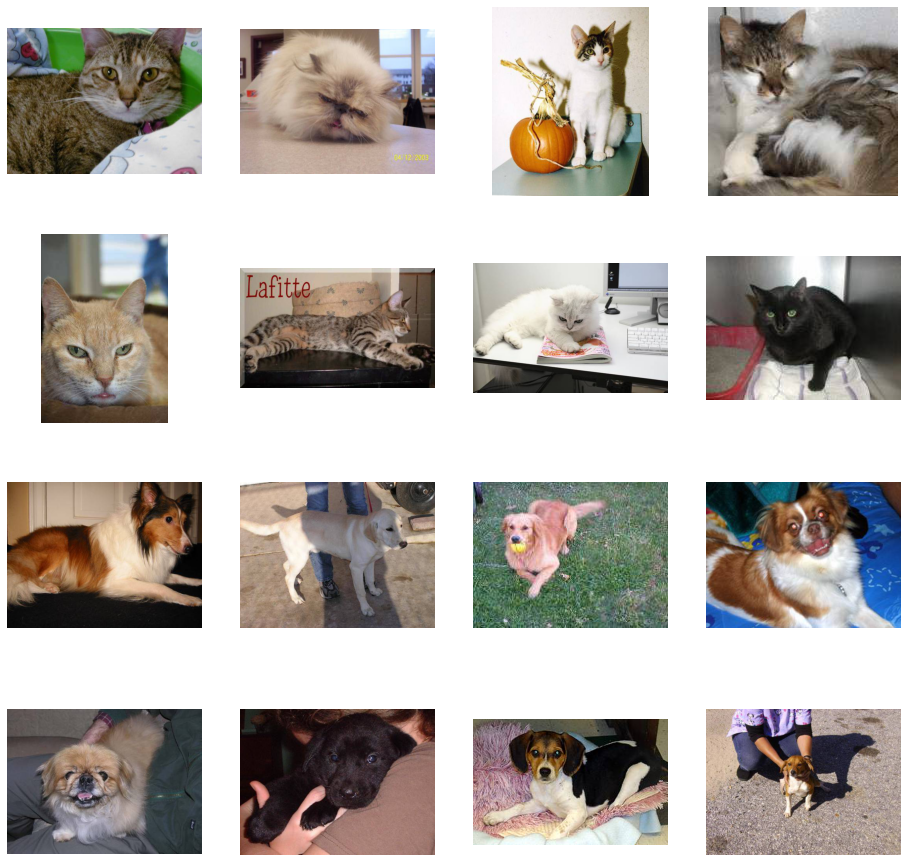

<Figure size 432x288 with 0 Axes>

In [45]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8
next_cat_pix = [os.path.join(cat_train_path, fname) for fname in os.listdir(cat_train_path)[ pic_index-8:pic_index]]
next_dog_pix = [os.path.join(dog_train_path, fname) for fname in os.listdir(dog_train_path)[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()
plot_path = "images.png"
plt.savefig(plot_path)

### Data Augmentation:
  - The importance of data augmentation technique is that it increases the amount of training data by modifying the existing training data's properties. For example, in image data, you can apply different preprocessing techniques such as rotate, flip, shear, or zoom on your existing images so you can simulate other data that the model should also learn from. This way, the model would see more variety in the images during training.

In [11]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_path,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## First Method: Defining the model from scratch

### Defining the model

In [12]:
def build_model():
  input = tf.keras.Input(shape = (150,150,3))
  model = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(input)
  model = tf.keras.layers.MaxPooling2D(2,2)(model)
  model = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(model)
  model = tf.keras.layers.MaxPooling2D(2,2)(model)
  model = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(model) 
  model = tf.keras.layers.MaxPooling2D(2,2)(model)
  # Flatten the results to feed into a DNN
  model = tf.keras.layers.Flatten()(model)
  # 512 neuron hidden layer
  model = tf.keras.layers.Dense(512, activation='relu')(model) 
  # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
  output = tf.keras.layers.Dense(1, activation='sigmoid')(model) 
  fina_model = Model(inputs=input, outputs=output)
  return fina_model

model = build_model()
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics = ['accuracy'])

In [13]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

In [14]:
history = model.fit(train_generator,steps_per_epoch=100,epochs=25,validation_data=validation_generator,validation_steps=50,verbose=1)

Epoch 1/25
100/100 [==============================] - 31s 195ms/step - loss: 0.7239 - accuracy: 0.5120 - val_loss: 0.7206 - val_accuracy: 0.5000
Epoch 2/25
100/100 [==============================] - 17s 171ms/step - loss: 0.6938 - accuracy: 0.5115 - val_loss: 0.6910 - val_accuracy: 0.5040
Epoch 3/25
100/100 [==============================] - 17s 172ms/step - loss: 0.6828 - accuracy: 0.5495 - val_loss: 0.6842 - val_accuracy: 0.5920
Epoch 4/25
100/100 [==============================] - 17s 171ms/step - loss: 0.6785 - accuracy: 0.5820 - val_loss: 0.6584 - val_accuracy: 0.6350
Epoch 5/25
100/100 [==============================] - 19s 192ms/step - loss: 0.6652 - accuracy: 0.5970 - val_loss: 0.6517 - val_accuracy: 0.6110
Epoch 6/25
100/100 [==============================] - 19s 186ms/step - loss: 0.6525 - accuracy: 0.6250 - val_loss: 0.6589 - val_accuracy: 0.6070
Epoch 7/25
100/100 [==============================] - 17s 169ms/step - loss: 0.6365 - accuracy: 0.6425 - val_loss: 0.6398 - val_ac

### Visualizing The loss and accuracy curves

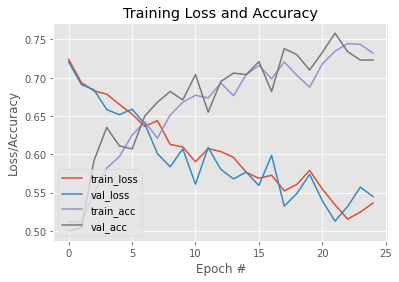

In [17]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
epochs = 25
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# saving the figure of accuracy and loss
plot_path = "plot.png"
plt.savefig(plot_path)

### Testing the model on input image

In [21]:
%%capture
!git clone https://github.com/MarwanMohamed95/Cat-Vs-Dog-Classification

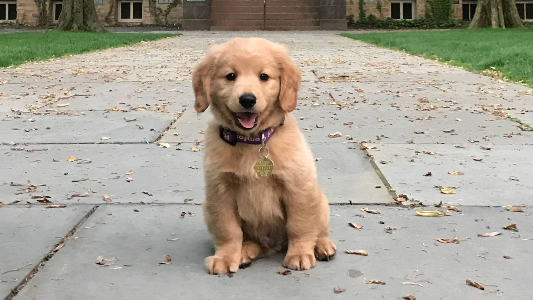

This is a dog


In [33]:
image_path = '/content/Cat-Vs-Dog-Classification/Dog.jpg'
image = cv2.imread(image_path)
(H,W) = image.shape[:2]
height = 300
width = int(height*W/H)
image = cv2.resize(image,(width,height))
cv2_imshow(image)
img = load_img(image_path,target_size=(150,150))
img = img_to_array(img)/255.0
img = np.expand_dims(img, axis=0)
classes = model.predict(img)[0]
if classes[0]>0.5:
    print("This is a dog")
else:
    print("This is a cat")

## The Second Method: Using Transfer Learning

Here we will apply transfer learning so we can use pre-trained weights in models such as InceptionV3 and add some layers to the end of it to match the problem we need.and at rhe end we will see alot of improve ment in  accuracy.

In [36]:
%%capture
# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use.we will use up to mixed_7 as your base model and add to that.

In [37]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [39]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics = ['accuracy'])

In [40]:
# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_97 (Conv2D)             (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [42]:
# Train the model.
history = model.fit(train_generator,validation_data = validation_generator,steps_per_epoch = 100,epochs = 15,validation_steps = 50,verbose = 1)

Epoch 1/15
100/100 [==============================] - 19s 192ms/step - loss: 0.1260 - accuracy: 0.9470 - val_loss: 0.0987 - val_accuracy: 0.9650
Epoch 2/15
100/100 [==============================] - 19s 192ms/step - loss: 0.1308 - accuracy: 0.9425 - val_loss: 0.0949 - val_accuracy: 0.9670
Epoch 3/15
100/100 [==============================] - 19s 192ms/step - loss: 0.1277 - accuracy: 0.9490 - val_loss: 0.0809 - val_accuracy: 0.9690
Epoch 4/15
100/100 [==============================] - 18s 184ms/step - loss: 0.1030 - accuracy: 0.9580 - val_loss: 0.0812 - val_accuracy: 0.9680
Epoch 5/15
100/100 [==============================] - 18s 181ms/step - loss: 0.1071 - accuracy: 0.9580 - val_loss: 0.0860 - val_accuracy: 0.9660
Epoch 6/15
100/100 [==============================] - 18s 181ms/step - loss: 0.1281 - accuracy: 0.9495 - val_loss: 0.0876 - val_accuracy: 0.9730
Epoch 7/15
100/100 [==============================] - 18s 182ms/step - loss: 0.1014 - accuracy: 0.9610 - val_loss: 0.0919 - val_ac

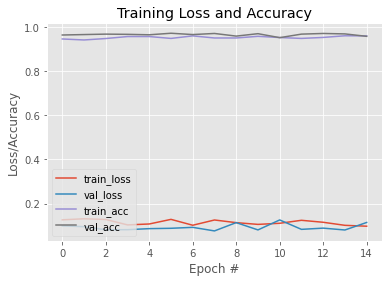

In [43]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
epochs = 15
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# saving the figure of accuracy and loss
plot_path = "plot2.png"
plt.savefig(plot_path)

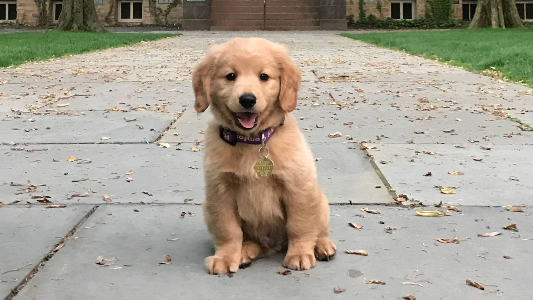

This is a dog


In [44]:
image_path = '/content/Cat-Vs-Dog-Classification/Dog.jpg'
image = cv2.imread(image_path)
(H,W) = image.shape[:2]
height = 300
width = int(height*W/H)
image = cv2.resize(image,(width,height))
cv2_imshow(image)
img = load_img(image_path,target_size=(150,150))
img = img_to_array(img)/255.0
img = np.expand_dims(img, axis=0)
classes = model.predict(img)[0]
if classes[0]>0.5:
    print("This is a dog")
else:
    print("This is a cat")